<a href="https://colab.research.google.com/github/RileyWClarke/MLTSA_COVID19/blob/master/Copy_of_COVID_19.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
% matplotlib inline

from fbprophet import Prophet

In [0]:
!pip install kaggle

In [3]:
from google.colab import drive

drive.mount("/content/gdrive")

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


In [4]:
cd gdrive/My\ Drive/


/content/gdrive/My Drive


In [5]:
ls kaggle.json

kaggle.json


In [0]:
!chmod 600 kaggle.json

In [0]:
import json
import os
envs = json.load(open("kaggle.json", "r"))
os.environ["KAGGLE_USERNAME"] = envs['username']
os.environ["KAGGLE_KEY"] = envs['key']

In [0]:
!mkdir COVID19


mkdir: cannot create directory ‘COVID19’: File exists


In [8]:
cd COVID19

/content/gdrive/My Drive/COVID19


In [0]:
!mkdir data

mkdir: cannot create directory ‘data’: File exists


In [9]:
cd data

/content/gdrive/My Drive/COVID19/data


In [0]:
!kaggle datasets download kimjihoo/coronavirusdataset

 40% 1.00M/2.53M [00:00<00:00, 4.47MB/s]
100% 2.53M/2.53M [00:00<00:00, 10.0MB/s]


In [0]:
!unzip coronavirusdataset.zip

Archive:  coronavirusdataset.zip
replace Case.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: n
replace PatientInfo.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: N
  inflating: SeoulFloating.csv       


In [9]:
ls

Case.csv                PatientRoute.csv  SeoulFloating.csv  TimeGender.csv
coronavirusdataset.zip  Region.csv        TimeAge.csv        TimeProvince.csv
PatientInfo.csv         SearchTrend.csv   Time.csv           Weather.csv


In [10]:
time = pd.read_csv('Time.csv')
time.head()

,date,time,test,negative,confirmed,released,deceased
0,2020-01-20,16,1,0,1,0,0
1,2020-01-21,16,1,0,1,0,0
2,2020-01-22,16,4,3,1,0,0
3,2020-01-23,16,22,21,1,0,0
4,2020-01-24,16,27,25,2,0,0


In [0]:
import plotly.express as px

In [0]:
time['date'] = pd.to_datetime(time['date'], format='%Y-%m-%d')

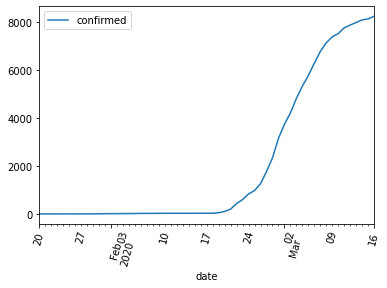

In [12]:
pd.plotting.register_matplotlib_converters()
time.plot(x='date',y='confirmed',rot = 75);

In [0]:
from fbprophet import Prophet, diagnostics
from fbprophet.diagnostics import cross_validation, performance_metrics
from fbprophet.plot import plot_cross_validation_metric, add_changepoints_to_plot, plot_plotly

In [0]:
confirmed_data=time.reset_index().rename(columns={'date':'ds','confirmed':'y'})

In [15]:
confirmed_data.tail()

,index,ds,time,test,negative,y,released,deceased
52,52,2020-03-12,0,234998,209402,7869,333,66
53,53,2020-03-13,0,248647,222728,7979,510,67
54,54,2020-03-14,0,261335,235615,8086,714,72
55,55,2020-03-15,0,268212,243778,8126,834,75
56,56,2020-03-16,0,274504,251297,8236,1137,75


### Using the default settings to make the prediction.

In [19]:
m=Prophet()
m.fit(confirmed_data)

future = m.make_future_dataframe(periods=30)
forecast = m.predict(future)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


,ds,yhat,yhat_lower,yhat_upper
82,2020-04-11,10501.641347,8514.343861,12433.048727
83,2020-04-12,10648.185336,8537.535205,12607.284694
84,2020-04-13,11038.501763,9056.867690,13095.770468
85,2020-04-14,10952.732247,8790.762616,13040.929054
86,2020-04-15,11086.080536,9065.963330,13106.070386


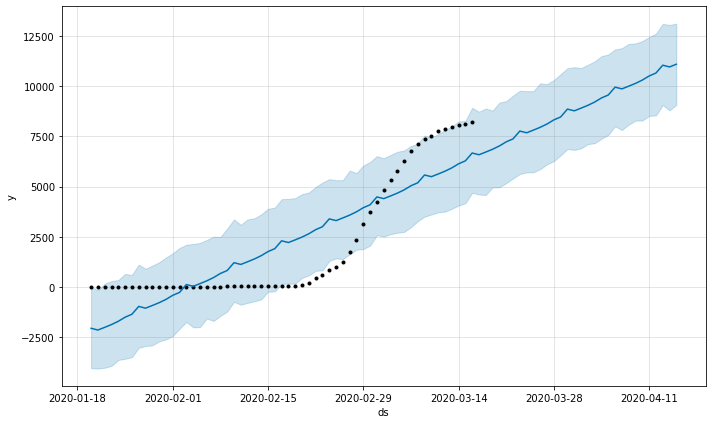

In [20]:
fig1 = m.plot(forecast)

**Figure 1.** It only fits the weekly seasonality.

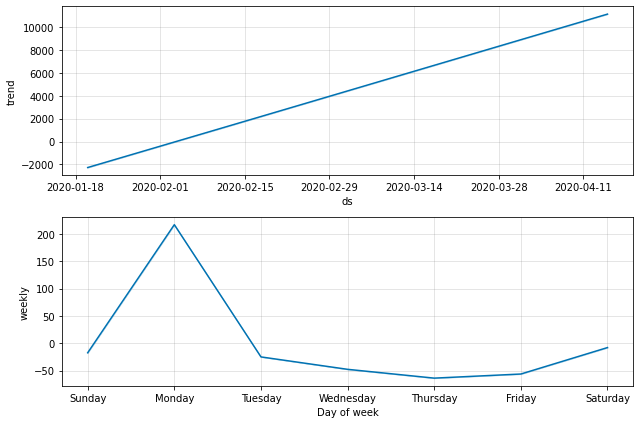

In [21]:
fig2 = m.plot_components(forecast)

### Try linear growth with only daily seasonality.

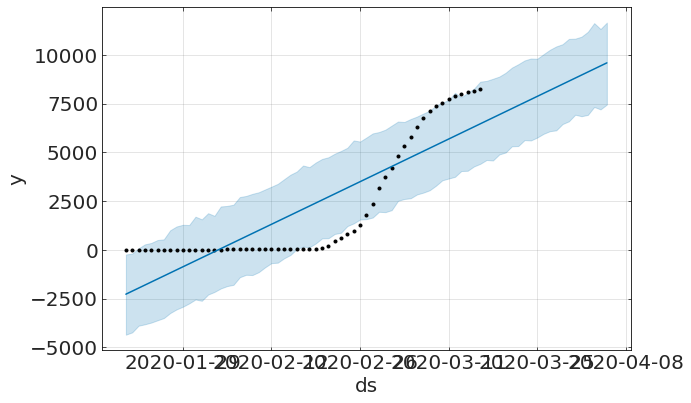

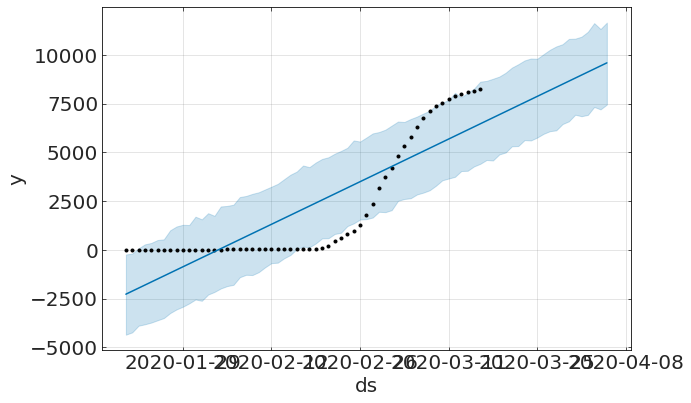

In [0]:
simp = Prophet(growth='linear',
    yearly_seasonality=False,
    weekly_seasonality = False,
    daily_seasonality = True,
    seasonality_mode = 'additive')
#confirmed_data['cap'] = 10000
simp.fit(confirmed_data)
future = simp.make_future_dataframe(periods=20)
forecast = simp.predict(future)
simp.plot(forecast)

In [0]:
confirmed_data.head()

,index,ds,time,test,negative,y,released,deceased,cap
0,0,2020-01-20,16,1,0,1,0,0,9000
1,1,2020-01-21,16,1,0,1,0,0,9000
2,2,2020-01-22,16,4,3,1,0,0,9000
3,3,2020-01-23,16,22,21,1,0,0,9000
4,4,2020-01-24,16,27,25,2,0,0,9000


### Try logistic growth with only daily seasonality.

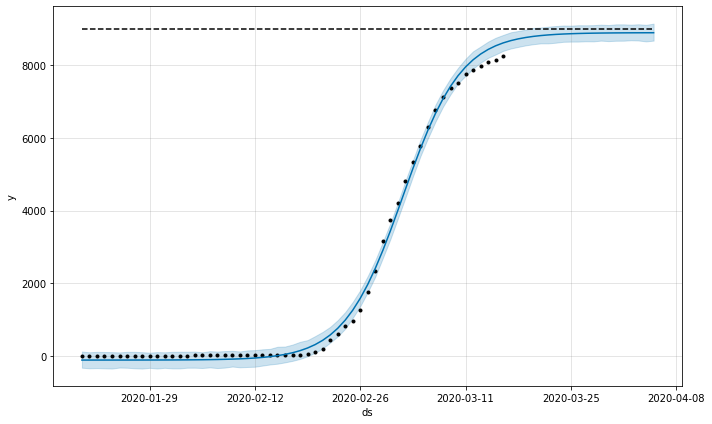

In [25]:
simlog = Prophet(growth='logistic',
    yearly_seasonality=False,
    weekly_seasonality = False,
    daily_seasonality = True,
    seasonality_mode = 'additive')
confirmed_data['cap'] = 9000
simlog.fit(confirmed_data)
future = simlog.make_future_dataframe(periods=20)
future['cap'] = 9000
forecast = simlog.predict(future)
fig4 = simlog.plot(forecast)

### Ajust parameters to make better fitting.

Set changepoints = ['2020-02-21', '2020-03-09']

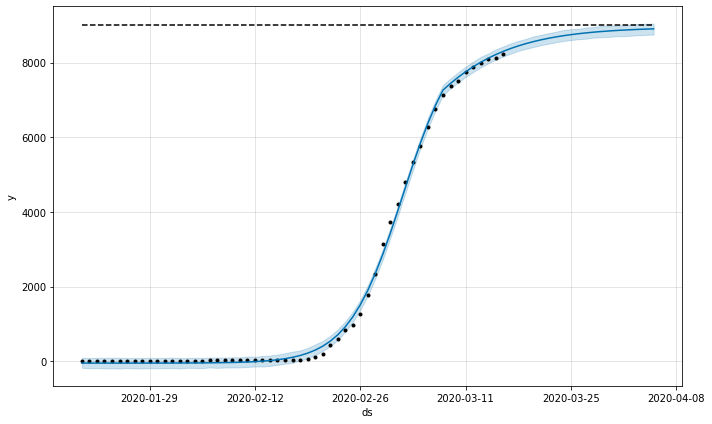

In [24]:
simlog2 = Prophet(growth='logistic',
    yearly_seasonality=False,
    weekly_seasonality = False,
    daily_seasonality = True,
    seasonality_mode = 'additive',
    changepoints = ['2020-02-21', '2020-02-25','2020-03-08'],
    changepoint_prior_scale=0.5)
confirmed_data['cap'] = 9000
simlog2.fit(confirmed_data)
future = simlog2.make_future_dataframe(periods=20)
future['cap'] = 9000
forecast = simlog2.predict(future)
fig4 = simlog2.plot(forecast)